# Backpropagation in NumPy

In this section we create a neural network and implement backpropagation from scratch using only NumPy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We create circular data, similar to the one we saw in the previous sections. That way we can focus solely on the algorithms and do not have to dvelwe into more complex techniques.

In [2]:
# create circular data
def circular_data():
    radii = [0.45, 0.25]
    center_x = 0.5
    center_y = 0.5
    num_points = 200
    X = []
    y = []
    
    for label, radius in enumerate(radii):
        for point in range(num_points):
            angle = 2 * np.pi * np.random.rand()
            feature_1 = radius * np.cos(angle) + center_x
            feature_2 = radius * np.sin(angle) + center_y
            
            X.append([feature_1, feature_2])     
            y.append([label])
            
    return np.array(X), np.array(y)

We generate datapoints for two distinct circles. Each datapoint basically consists of an `(x,y)` coordinates pair. The category 0 datapoints form a cirlcle with a radius 0.45, while the datapoints with category 1 form a circle with a radius 0.25. There are 200 samples for each circle category.

In [3]:
X, y = circular_data()
print(f'The shape of the features matrix is {X.shape}')
print(f'The shape of the features matrix is {y.shape}')

The shape of the features matrix is (400, 2)
The shape of the features matrix is (400, 1)


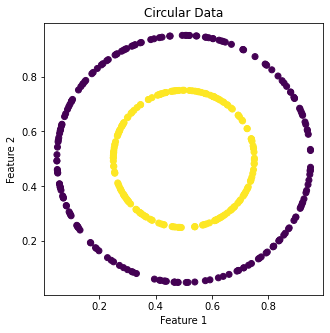

In [4]:
feature_1 = X.T[0]
feature_2 = X.T[1]
# plot the circle
plt.figure(figsize=(5,5))
plt.scatter(x=feature_1, y=feature_2, c=y)
plt.title("Circular Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

For an easier implementation we create a `NeuralNetwork` class with several key methods.

- In the `__init__` method we initialize the class. The method requires the features matrix $\mathbf{X}$, the true label vector $\mathbf{y}$, the learning rate $\alpha$ and the list `shape`, that contains the number of neurons per layer. We initalize weights and biases with small random values using the standard normal distribution.

- The `forward` method works as expected. The features matrix $\mathbf{X}$ is transformed by applying linear transformations and the sigmoid activation function one layer at a time until the output layer is reached. We save intermediary neuron outputs in a Python list, as we will need those values in the backward step.

- The `sigmoid` method and the `loss` methods are self descriptive. We implement those in order to avaid repititions.

- The `backward` function implements the backpropagation algorithm. We calculate the deltas $\delta$, that can be reused over and over again.

- The `step` method uses gradient descent and adjusts weights and biases.

In [5]:
class NeuralNetwork:
    
    def __init__(self, X, y, shape=[2, 4, 2, 1], alpha = 0.1):
        self.X = X
        self.y = y
        self.alpha = alpha
        
        self.weights = []
        self.biases = []
        self.activations = []
        self.num_layers = len(shape)
        self.W_grads = []
        self.b_grads = []
        
        # initialize weights and matrices with random numbers
        for num_features, num_neurons in zip(shape[:-1], shape[1:]):
            weight_matrix = np.random.randn(num_neurons, num_features)
            self.weights.append(weight_matrix)
            bias_vector = np.random.randn(1, num_neurons)
            self.biases.append(bias_vector)
        
    def forward(self):
        # save activations for later, as those are needed for backprop and the calculation of the loss
        self.activations = []
        A = X
        self.activations.append(X)
        for W, b in zip(self.weights, self.biases):
            Z = A @ W.T + b
            A = self.sigmoid(Z)
            self.activations.append(A)
            
    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
        
    def loss(self):
        y_hat = self.activations[-1]
        loss =  -(self.y * np.log(y_hat) + (1 - self.y) * np.log(1 - y_hat)).mean()
        return loss
    
    def backward(self):
        # empty gradients
        self.W_grads = []
        self.b_grads = []
        
        # get the predictions of the neural network
        y_hat = self.activations[-1]
        # gradients of the loss with respect to output
        dL_da = (1 - self.y) * 1 / (1 - y_hat) - (self.y * 1 / y_hat)
        dL_da = dL_da / self.X.shape[0]
        
        delta = None
        # we apply backprop one layer at a time
        # from last layer to first layer
        activations = reversed(self.activations[1:])
        prev_activations = reversed(self.activations[:-1])
        for layer, (A, A_prev) in enumerate(zip(activations, prev_activations)):
            if delta is None:
                da_dz = A * (1 - A)
                delta = dL_da * da_dz
                
            else:
                weight_idx = self.num_layers - layer - 1
                W = self.weights[weight_idx]
                # delta is always the gradient with respect to the net inputs z
                # A * (1 - A) is the sigmoid derivative
                delta = (delta @ W) * A * (1 - A)
            
            dz_dw = A_prev
            dL_dw = delta.T @ dz_dw
            dL_db = delta.sum(axis=0)
            
            self.W_grads.append(dL_dw)
            self.b_grads.append(dL_db)
        
        self.W_grads = reversed(self.W_grads)
        self.b_grads = reversed(self.b_grads)
                        
    # update weights
    def step(self):
        for idx, (W, dW) in enumerate(zip(self.weights, self.W_grads)):
            self.weights[idx] = W - self.alpha * dW
         
        for idx, (b, db) in enumerate(zip(self.biases, self.b_grads)):
            self.biases[idx] = b - self.alpha * db

In [6]:
nn = NeuralNetwork(X, y)

In [7]:
epochs = 50_000

In the trainig loop we always take the forward pass first, calculate the gradients second and finally apply gradient descent. You will see the same pattern, once we switch to PyTorch.

In [8]:
# training loop
for epoch in range(epochs):
    nn.forward()
    if epoch % 10000 == 0:
        print(nn.loss())
    nn.backward()
    nn.step()
print(nn.loss())

0.7290816741778516
0.6869300981265652
0.507736996357617
0.403515758316546
0.011207910865046697
0.004374423387275728


You can see that the cross-entropy loss keeps decreasing and approaches 0 after 50,000 epochs.